In [1]:
## config, edit
# https://docs.esmvaltool.org/projects/ESMValCore/en/latest/api/esmvalcore.config.html
from esmvalcore.config import CFG
from esmvalcore.dataset import Dataset
CFG.load_from_file('/home/189/fc6164/esmValTool/config-fc-copy.yml')

### eq_SST_sea_cycle: zonal structure of the amplitude of the mean seasonal cycle of SST in the equatorial Pacific

Computes the zonal root mean square error (RMSE) of of equatorial Pacific (150°E-90°W) amplitude (standard deviation) of the mean annual cycle (zonal 5°S-5°N average) sea surface temperature (SST) between model and observations (the time averaging creates a 12 months mean annual cycle time series from which the standard deviation is computed)

https://github.com/CLIVAR-PRP/ENSO_metrics/wiki/SeasonalSstLonRmse

## Dataset

In [9]:
# TropFlux 1979-2018 (main)
# 20CRv2 1871-2012, ERA-Interim 1979-2018, ERSSTv5 1854-2018, HadISST 1870-2018, NCEP2 1979-2018
# Dataset:
#  {'dataset': 'HadISST',
#   'project': 'OBS',
#   'mip': 'Omon',
#   'short_name': 'tos',
#   'tier': 'Tier2',
#   'timerange': '*',
#   'type': '*',
#   'version': '*'}
# {'dataset': 'NOAA-ERSSTv5',
#   'project': 'OBS6',
#   'mip': 'Omon',
#   'short_name': 'tos',
#   'tier': 'Tier2',
#   'timerange': '*',
#   'type': '*',
#   'version': '*'}

obs = Dataset(dataset= '*', project= 'OBS6', type= '*', version='*', 
                    timerange='*', tier='*', mip='*', short_name='tos')
list(obs.from_files())
# len(obs.files)

[Dataset:
 {'dataset': 'NOAA-ERSSTv3b',
  'project': 'OBS6',
  'mip': 'Omon',
  'short_name': 'tos',
  'tier': 'Tier2',
  'timerange': '*',
  'type': '*',
  'version': '*'},
 Dataset:
 {'dataset': 'NOAA-ERSSTv5',
  'project': 'OBS6',
  'mip': 'Omon',
  'short_name': 'tos',
  'tier': 'Tier2',
  'timerange': '*',
  'type': '*',
  'version': '*'},
 Dataset:
 {'dataset': 'WOA',
  'project': 'OBS6',
  'mip': 'Omon',
  'short_name': 'tos',
  'tier': 'Tier2',
  'timerange': '*',
  'type': '*',
  'version': '*'},
 Dataset:
 {'dataset': 'ERA-Interim',
  'project': 'OBS6',
  'mip': 'Omon',
  'short_name': 'tos',
  'tier': 'Tier3',
  'timerange': '*',
  'type': '*',
  'version': '*'}]

In [10]:

## model
var = Dataset(
    short_name='tos',
    mip='Omon',
    project='CMIP6',
    activity='CMIP',
    dataset='ACCESS-CM2',
    ensemble='r1i1p1f1',
    institute='*',
    grid='*',
    exp='historical',
    timerange='*',
    # derive='true'
)
list(var.from_files())[0].files
var.files


[LocalFile('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Omon/tos/gn/v20191108/tos_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc')]

Regridding:
model and observations regridded toward a generic 1°x1° grid (using cdms esmf linear method)

Steps (computation):
- detrending (if applicable)
- mean annual cycle computation
- standard deviation computation
- regridding (if applicable)
- meridional average
- RMSE computation

In [11]:
import iris
from esmvalcore.preprocessor import (
                detrend, # dimension, method, 
                meridional_statistics, # for zonal 5°S-5°N average meridional
                regrid, #esmf bilinear
                mask_landsea,
                extract_region, # equatorial pacific #1 - 150°E-90°W, zonal 5°S-5°N average
                climate_statistics ) # month mean, standard deviation


In [29]:
cube = var.load()
cube = regrid(cube, '1x1', {'reference':'esmf_regrid.schemes:ESMFBilinear'})
cube = extract_region(cube, 130, 290, -15,15) #90-270, -5,5 for plot

cube = climate_statistics(cube,'mean',period='monthly')
print(cube.data.max(),cube.data.min(), cube.units)

# level 3 hovmoller diagram - meridional
cube_3 = extract_region(cube, 150, 270, -5,5)
cube_3 = meridional_statistics(cube_3, 'mean')

# cube = climate_statistics(cube,'std_dev')
cube = cube.collapsed('month_number', iris.analysis.STD_DEV)

print(cube.data.max(),cube.data.min(),cube.units)
cube


31.559721 20.107903 degC
2.525292078725136 0.10752226301306966 degC


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'month_number', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'month_number'. Ignoring bounds.
  warnings.warn(


<iris 'Cube' of sea_surface_temperature / (degC) (latitude: 30; longitude: 160)>

degC


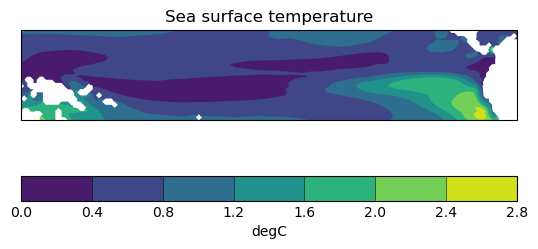

In [30]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import iris.quickplot as qplt

proj = ccrs.PlateCarree(central_longitude=210.0)
plt.subplot(projection=proj)
print(cube.units)
qplt.contourf(cube)

# plt.gca().coastlines()
# ticks longitude, lat, arrow legend

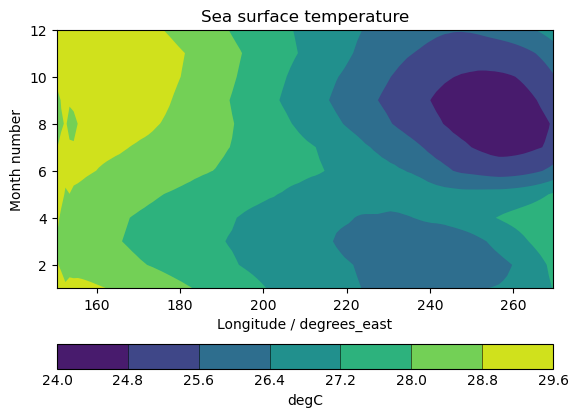

In [27]:

qplt.contourf(cube_3)

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(


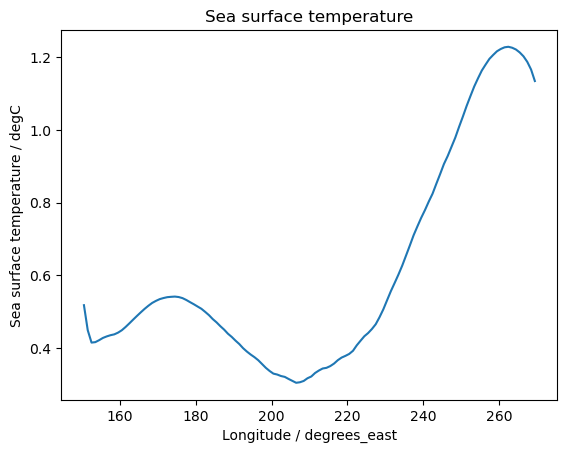

In [28]:
# rmse calc

cube = extract_region(cube, 150, 270, -5,5)

cube = meridional_statistics(cube, 'mean')
qplt.plot(cube)

In [ ]:
regrid(cube_tas, '1.5x1.5', {'reference':'esmf_regrid.schemes:ESMFAreaWeighted' ,'use_src_mask':True})
